In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver

In [17]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [18]:
range_model=np.array([[-1,1],[-1,1]])
clipped=np.clip(range_model,-1,1)
((range_model[:,1:]-range_model[:,:1]).T*np.random.rand(1000,2)+range_model[:,:1].T)

array([[ 0.29105937, -0.90124082],
       [ 0.51930981,  0.79411231],
       [ 0.76236402,  0.42149062],
       ...,
       [-0.21949126,  0.46208743],
       [ 0.99563591, -0.46564601],
       [-0.94152828, -0.84324866]])

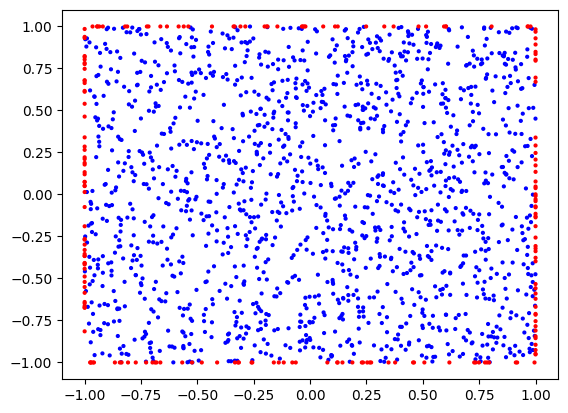

In [19]:
int_point_number=1500
ext_point_number=200
X_int=make_points_inside(int_point_number)
X_boundary=make_points_boundary(ext_point_number)
X_all=np.concatenate([X_int,X_boundary])
plt.scatter(X_all[:,0],X_all[:,1],c=['b']*int_point_number+['r']*ext_point_number,s=4)

In [20]:
from sympy import cos,sin,pi,symbols,diff,lambdify

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=u_symbolic**3-laplacian(u_symbolic)
f_symbolic

cos(4*pi*x)**3*cos(pi*y/2)**3 + 65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

In [21]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2

In [22]:
u=PDESolver(X_int=X_int,X_boundary=X_boundary,sigma=0.1)
u.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 9.199e-09: : 4it [00:05,  1.31s/it]


In [23]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

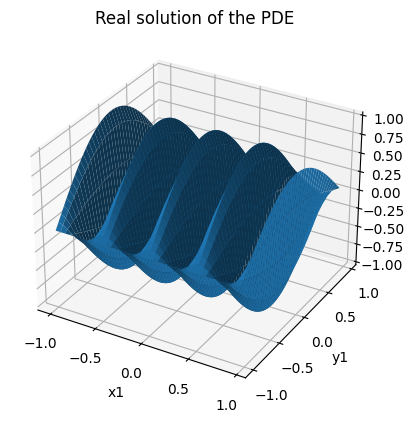

In [24]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

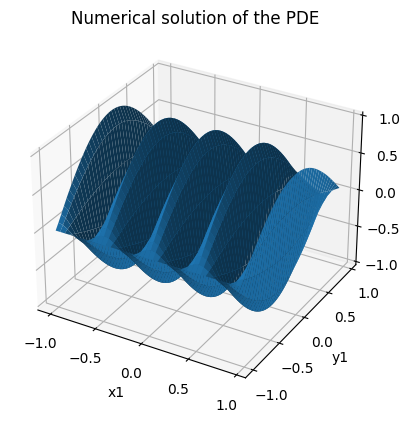

In [25]:
fig=plot_vectorized_function(u)
plt.title('Numerical solution of the PDE')
plt.show()

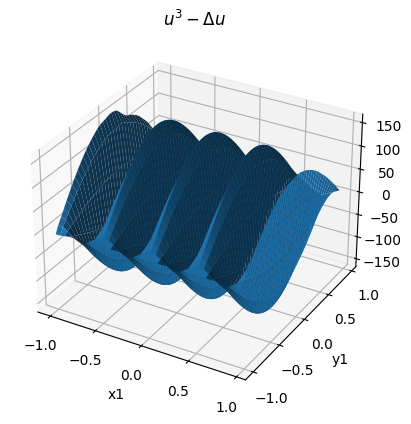

In [26]:
fig=plot_vectorized_function(lambda x:u(x)**3-u.laplacian(x))
#fig=plot_vectorized_function(lambda x:u.laplacian(x))
plt.title('$u^3-\Delta u$')
plt.show()

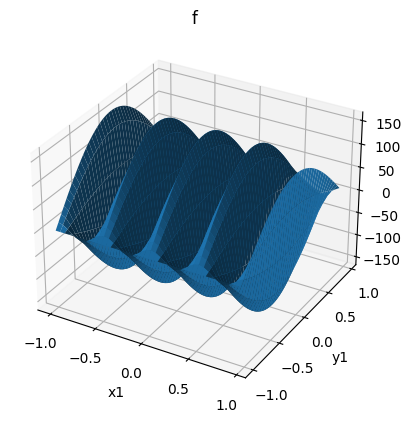

In [27]:
fig=plot_function(f)
plt.title('f')
plt.show()

In [28]:
X_int_left=make_points_inside(int_point_number)
X_int_right=make_points_inside(int_point_number)
X_boundary_left=make_points_boundary(ext_point_number)
X_boundary_right=make_points_boundary(ext_point_number)

In [29]:
sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
print((pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean())
sigma=0.1

0.026155671779570837


In [49]:
u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<-0.2],X_boundary=X_boundary_left,sigma=sigma,name='left')
u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>0.2],X_boundary=X_boundary_right,sigma=sigma,name='right')
u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 6.814e-08: : 6it [00:00,  7.21it/s]
Current residual 4.680e-07: : 6it [00:00,  9.99it/s]


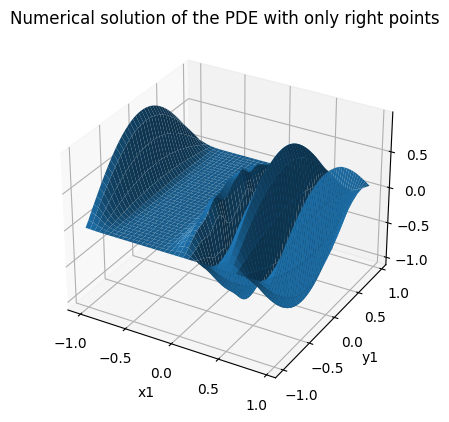

In [50]:
fig=plot_vectorized_function(u_right)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

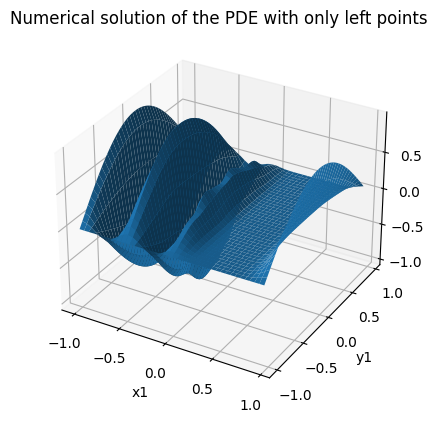

In [51]:
fig=plot_vectorized_function(u_left)
plt.title('Numerical solution of the PDE with only left points')
plt.show()

In [52]:
aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=1e-5)

M [[ 1.22141139e-03  7.31608117e-03]
 [-1.40167716e-05  5.00800176e-03]
 [ 1.43359342e-04  2.10692232e-03]
 ...
 [ 2.55401535e-02 -2.40944002e-02]
 [ 4.77217621e-02  2.42435382e-02]
 [ 6.94314568e-02  6.35722327e-02]]
COV mat [[[0.999318   0.99347467]
  [0.99347467 0.99376872]]

 [[1.00000484 0.93899765]
  [0.93899765 0.93899903]]

 [[0.9999622  0.95427072]
  [0.95427072 0.95432158]]

 ...

 [[0.80205305 0.80204244]
  [0.80204244 1.0000049 ]]

 [[0.8601634  0.86014978]
  [0.86014978 1.00000891]]

 [[0.95102563 0.95102148]
  [0.95102148 1.00000813]]]
COV Y [[0.999308   0.99375872]
 [0.99999484 0.93898903]
 [0.9999522  0.95431158]
 ...
 [0.80204305 0.9999949 ]
 [0.8601534  0.99999891]
 [0.95101563 0.99999813]]
alpha [[9.52102075e-01 4.81695809e-02]
 [9.99977450e-01 1.33658278e-05]
 [9.98888156e-01 1.15460121e-03]
 ...
 [5.43593402e-05 9.99946402e-01]
 [1.01550953e-04 9.99902652e-01]
 [7.85275486e-05 9.99915319e-01]]


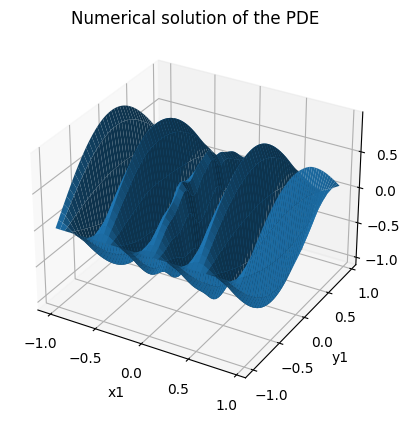

In [53]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [35]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))


M [[0.00121864 0.00731623]
 [0.0007336  0.00699948]
 [0.00037639 0.00659213]
 ...
 [0.01394391 0.01525573]
 [0.01429855 0.0158346 ]
 [0.01451919 0.01605731]]
COV mat [[[0.99931852 0.99347475]
  [0.99347475 0.99376872]]

 [[0.99972721 0.98936534]
  [0.98936534 0.98956601]]

 [[0.99990841 0.97832028]
  [0.97832028 0.97844291]]

 ...

 [[0.9989835  0.99894025]
  [0.99894025 0.99996892]]

 [[0.99944796 0.99938446]
  [0.99938446 0.99994989]]

 [[0.99974407 0.99965785]
  [0.99965785 0.99993201]]]
COV Y [[0.99930852 0.99375872]
 [0.99971721 0.98955601]
 [0.99989841 0.97843291]
 ...
 [0.9989735  0.99995892]
 [0.99943796 0.99993989]
 [0.99973407 0.99992201]]
alpha [[0.95211847 0.04815311]
 [0.98100507 0.01918376]
 [0.99435195 0.00576246]
 ...
 [0.04037949 0.95965205]
 [0.10100321 0.89904391]
 [0.23929143 0.76076418]]


In [36]:
np.linalg.norm(U-U_real,ord=np.inf)

0.007893344149572878

In [54]:
x_sample=np.array([[0,0]])
print(real_u(x_sample[0]))
aggregate(x_sample)

1.0
M [[0.37487723 0.4552354 ]]
COV mat [[[0.52305901 0.09629245]
  [0.09629245 0.46959802]]]
COV Y [[0.52304901 0.46958802]]
alpha [[0.84789742 0.82611486]]


array([0.69393416])

In [ ]:
u_left.covariate_with_sol(x_sample)

array([0.99999998])

In [ ]:
u_left.sigma

0.1

In [ ]:
u_left.covariate_with_sol(x_sample,0.1)

array([1.00000932])

In [ ]:
u_left.covariate_with_other(u_left,x_sample,1e-6)

array([2.03367653e+20])

In [ ]:
cov_left=u_left.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_right=u_right.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_inter=u_right.covariate_with_other(u_left,np.stack([X.flatten(),Y.flatten()],axis=-1),sigma=0.1)
alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))

COV mat [[[0.99999615 0.99991889]
  [0.99991889 0.999943  ]]

 [[1.00000212 0.99998062]
  [0.99998062 0.99999854]]

 [[1.00000513 0.9999902 ]
  [0.9999902  1.00000503]]

 ...

 [[0.99910912 0.99909804]
  [0.99909804 1.00001066]]

 [[0.99958188 0.99957125]
  [0.99957125 1.00001065]]

 [[0.99988883 0.99987806]
  [0.99987806 1.00000985]]]
COV Y [[0.99998615 0.999933  ]
 [0.99999212 0.99998854]
 [0.99999513 0.99999503]
 ...
 [0.99909912 1.00000066]
 [0.99957188 1.00000065]
 [0.99987883 0.99999985]]


In [ ]:
np.max(np.abs(np.sum(alpha,axis=-1)-1))

0.0002489476421954073

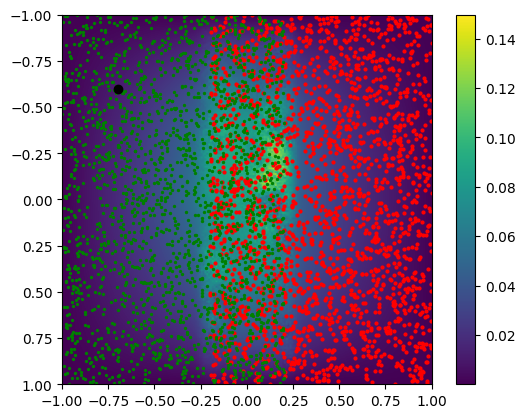

In [ ]:
ax=plt.subplot()
im = ax.imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
ax.scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
ax.scatter(x_sample[:,0],x_sample[:,1],c='k')
plt.colorbar(im)

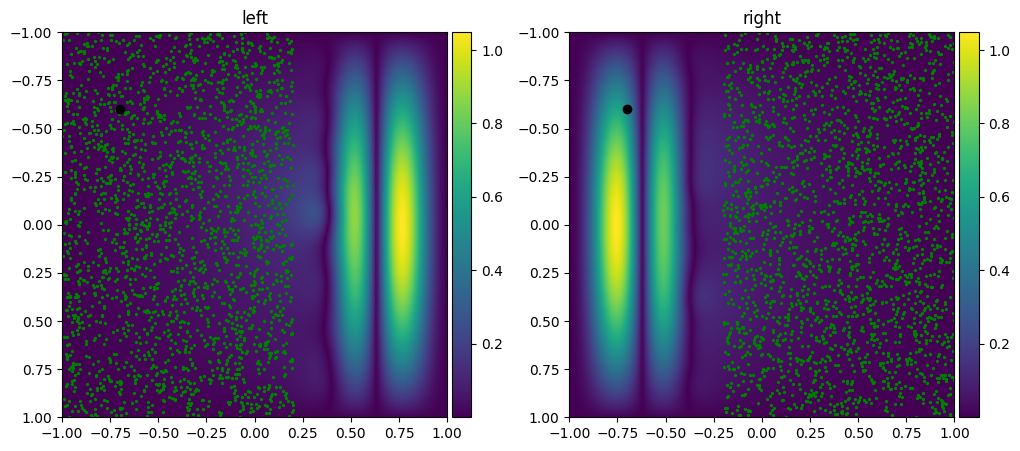

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.abs(U_left-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U_right-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

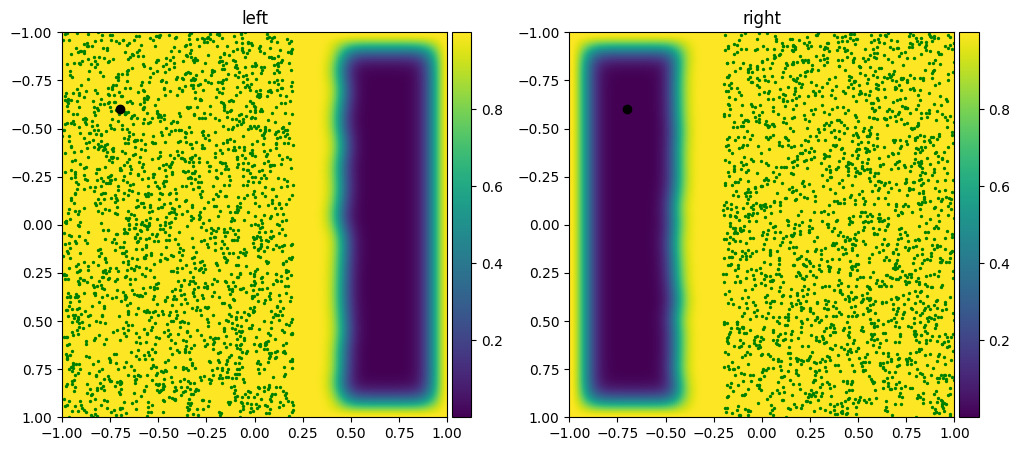

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(cov_left.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(cov_right.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

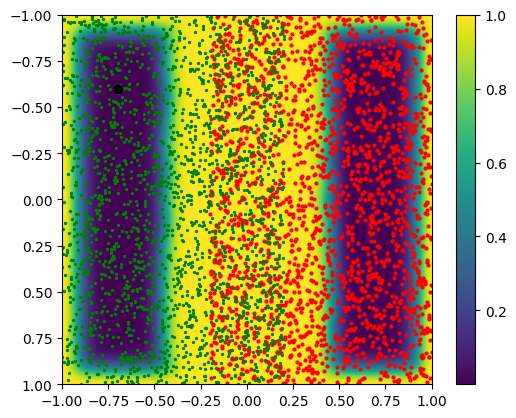

In [ ]:
ax=plt.subplot()
im = ax.imshow(cov_inter.reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
ax.scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
ax.scatter(x_sample[:,0],x_sample[:,1],c='k')
plt.colorbar(im)

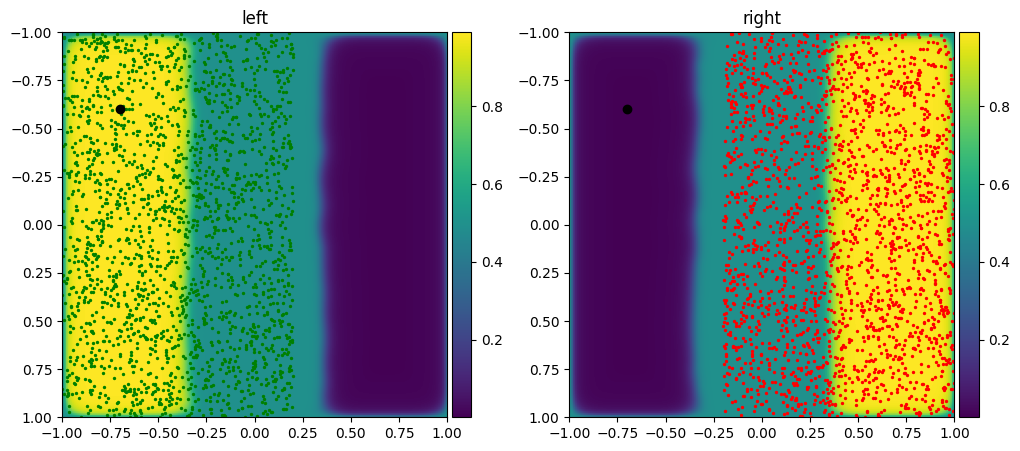

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [34]:
def make_an_aggregate(N_int,N_boundary):
    X_int_left=make_points_inside(N_int)
    X_int_right=make_points_inside(N_int)
    X_boundary_left=make_points_boundary(N_boundary)
    X_boundary_right=make_points_boundary(N_boundary)
    sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
    u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left[X_boundary_left[:,0]<0.2],sigma=sigma,name='left')
    u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
    u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right[X_boundary_right[:,0]>-0.2],sigma=sigma,name='right')
    u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

    aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=1e-4)
    return u_left,u_right,aggregate

def get_error(aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    return np.linalg.norm(U_real-U_agg),np.linalg.norm(U_real-U_agg,ord=np.inf)

def make_plot(u_left,u_right,aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))
    alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))


    fig,axes=plt.subplots(3,2,figsize=(30,30))
    im = axes[0,0].imshow(np.abs(U_left-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[0,0].title.set_text('error of left model')

    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im2 = axes[0,1].imshow(np.abs(U_right-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=4)
    axes[0,1].title.set_text('error of right model')

    divider = make_axes_locatable(axes[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')


    im3 = axes[1,0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,0].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[1,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=6)
    axes[1,0].title.set_text('error of aggregate')
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    im4 = axes[1,1].imshow(np.abs(U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,1].title.set_text('absolute value of solution')
    divider = make_axes_locatable(axes[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')

    im5 = axes[2,0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[2,0].title.set_text('alpha left')

    divider = make_axes_locatable(axes[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical')

    im6 = axes[2,1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[2,1].title.set_text('alpha right')

    divider = make_axes_locatable(axes[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical')

    plt.show()

    


In [35]:
u_left,u_right,aggregate=make_an_aggregate(N_int=10000,N_boundary=1000)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
make_plot(u_left,u_right,aggregate)

M [[ 5.15761422e-004 -6.19552716e-157]
 [ 1.14283268e-004 -4.32371226e-153]
 [ 9.51213397e-006 -2.69854607e-149]
 ...
 [ 9.36268389e-146  1.51252445e-002]
 [ 1.64241378e-149  1.56403057e-002]
 [ 2.57665629e-153  1.59235209e-002]]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/theobourdais/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_79419/3635802386.py", line 1, in <module>
    make_plot(u_left,u_right,aggregate)
  File "/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_79419/3864932853.py", line 26, in make_plot
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 174, in __call__
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 166, in alpha
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 154, in inner_models_cov_matrix
    covs=np.array(list(map(lambda model_pair:Aggregate.covariate_models(model_pair[0],model

# Local convergence

In [ ]:
X_local=make_points_inside(Nd=2000,range=np.array[[-0.2,0.1],[-0.2,0.1]])
X_boundary_local=make_points_boundary(200)
u_local=PDESolver(X_int=X_local,X_boundary=X_boundary_local,sigma=0.1,name='local')
u_local.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 3.468e-07: : 8it [00:24,  3.05s/it]


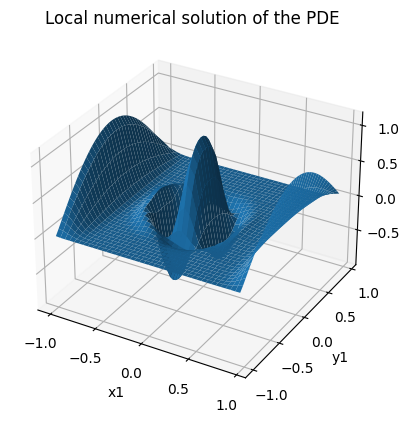

In [ ]:
fig=plot_vectorized_function(u_local)
plt.title('Local numerical solution of the PDE ')
plt.show()

In [ ]:
x = y = np.arange(-0.2, 0.1, 0.1)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_loc= u_local(np.stack([X.flatten(),Y.flatten()],axis=-1))

In [ ]:
np.linalg.norm(U_real-U_loc,ord=np.inf)

0.45111099011852623

# Aggregating many models

In [ ]:
def aggregate_many_models(N_models,N_points_inside,buffer_size,sigma,nugget_aggregate,nugget_model=1e-5):
    models=[]
    for k in range(N_models**2):
        kx=k%N_models
        ky=k//N_models
        range_model=np.array([
            [-1+kx/N_models*2-buffer_size,-1+(kx+1)/N_models*2+buffer_size],
            [-1+ky/N_models*2-buffer_size,-1+(ky+1)/N_models*2+buffer_size]
            ])
        models.append(PDESolver(X_int=make_points_inside(Nd=N_points_inside,range_model=range_model),
                  X_boundary=make_points_boundary(N_points_inside//10),
                  sigma=sigma,
                  name=f'model_{k}'))
        models[-1].fit(f,real_u,tau,dtau,nugget=nugget_model)
    return Aggregate(models,sigma=sigma,nugget=nugget_aggregate)


In [ ]:
big_aggregate=aggregate_many_models(N_models=3,N_points_inside=1000,buffer_size=0.0,sigma=0.1,nugget_aggregate=1e-5,nugget_model=1e-5)

Current residual 5.455e-07: : 6it [00:02,  2.56it/s]
Current residual 5.581e-08: : 8it [00:02,  3.57it/s]
Current residual 4.520e-07: : 6it [00:01,  3.65it/s]
Current residual 1.046e-07: : 8it [00:02,  3.96it/s]
Current residual 7.935e-07: : 7it [00:01,  3.84it/s]
Current residual 1.380e-07: : 8it [00:02,  3.93it/s]
Current residual 3.346e-08: : 8it [00:02,  3.96it/s]
Current residual 9.670e-08: : 8it [00:02,  3.96it/s]
Current residual 4.454e-07: : 6it [00:01,  3.97it/s]


M [[-6.44743135e-05  1.49632773e-03  7.69889068e-03 ...  3.15626711e-02
   1.68221862e-03  5.40859219e-05]
 [ 8.62946725e-05  2.31462567e-04  1.37849915e-05 ...  1.24694655e-02
   9.25304273e-04 -3.74160991e-06]
 [ 6.39353630e-06  4.06071789e-03  3.38699879e-04 ...  3.45618462e-04
   2.23522810e-04 -1.33821909e-08]
 ...
 [ 2.36029530e-02  2.58414259e-02  2.38072073e-02 ...  1.05448737e-02
   1.99381982e-02 -2.17715570e-02]
 [ 4.63624722e-02  4.82870212e-02  4.44039922e-02 ...  1.92191277e-02
   3.98146955e-02  2.59206785e-02]
 [ 6.90015124e-02  7.03189159e-02  6.50138375e-02 ...  2.83856813e-02
   6.38675378e-02  6.43434542e-02]]
COV mat [[[1.00000937 0.99954936 0.98994814 ... 0.72674018 0.99955435 0.99958647]
  [0.99954936 0.99956151 0.99017586 ... 0.72733701 0.9993006  0.99916734]
  [0.98994814 0.99017586 0.98995843 ... 0.72467289 0.98996025 0.99009999]
  ...
  [0.72674018 0.72733701 0.72467289 ... 0.7267482  0.72692423 0.72619792]
  [0.99955435 0.9993006  0.98996025 ... 0.72692423 0

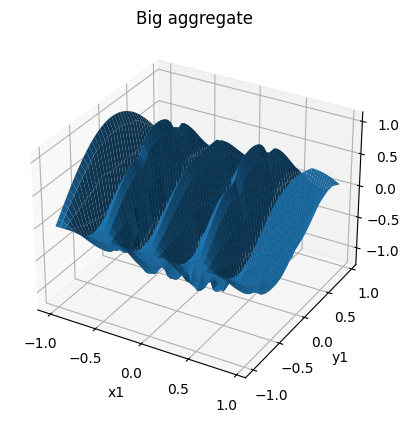

In [ ]:
fig=plot_vectorized_function(big_aggregate)
plt.title('Big aggregate')
plt.show()

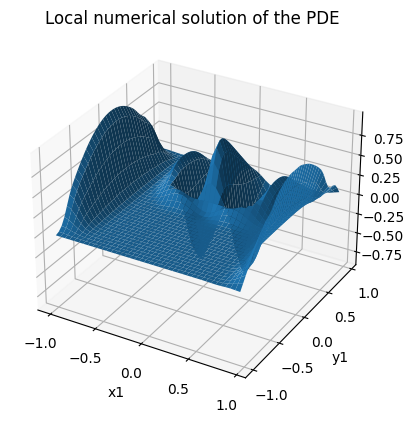

In [ ]:
fig=plot_vectorized_function(big_aggregate.models[7])
plt.title('Local numerical solution of the PDE ')
plt.show()

In [ ]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U_agg= big_aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha=big_aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)

M [[-6.44743135e-05  1.49632773e-03  7.69889068e-03 ...  3.15626711e-02
   1.68221862e-03  5.40859219e-05]
 [-5.30114289e-06  7.20107961e-04  5.09781792e-03 ...  2.79305293e-02
   1.55929459e-03  2.31944138e-05]
 [ 3.95049860e-05  1.94267468e-04  3.04552986e-03 ...  2.40557793e-02
   1.41689285e-03  5.01350261e-06]
 ...
 [ 2.73166306e-02  1.45264015e-02  1.45791163e-02 ...  4.56649106e-03
   2.37662240e-02  1.47107671e-02]
 [ 2.81615178e-02  1.49207493e-02  1.60213334e-02 ...  4.99739577e-03
   2.56228630e-02  1.52717620e-02]
 [ 2.87157494e-02  1.51746435e-02  1.76333821e-02 ...  5.41917753e-03
   2.72032997e-02  1.55914143e-02]]
COV mat [[[1.00000937 0.99954936 0.98994814 ... 0.72674018 0.99955435 0.99958647]
  [0.99954936 0.99956151 0.99017586 ... 0.72733701 0.9993006  0.99916734]
  [0.98994814 0.99017586 0.98995843 ... 0.72467289 0.98996025 0.99009999]
  ...
  [0.72674018 0.72733701 0.72467289 ... 0.7267482  0.72692423 0.72619792]
  [0.99955435 0.9993006  0.98996025 ... 0.72692423 0

In [ ]:
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)

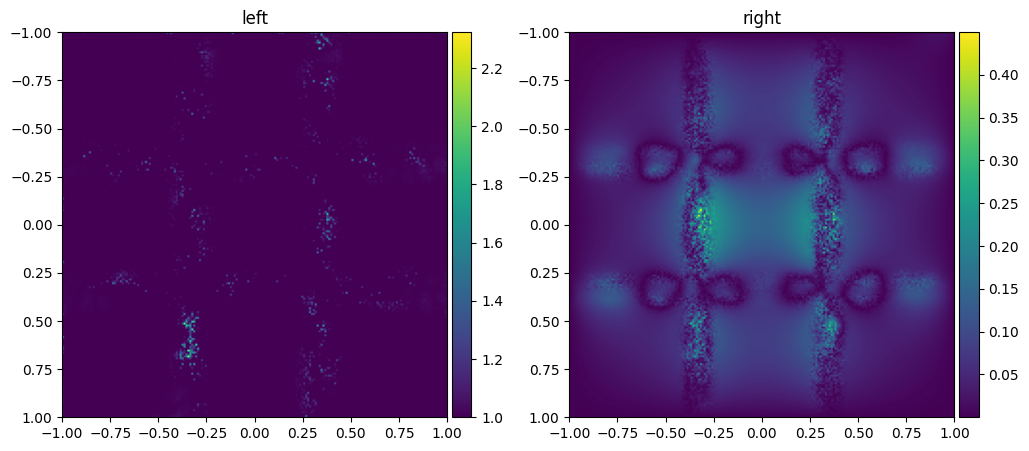

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha_norm.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(error_big_agg.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')